In [ ]:
# Подключение к Google диску

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

import tensorflow as tf
import skimage.io as io
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

### Загрузка данных и клонирование репозитория

In [ ]:
if 1:
    !mkdir -p data

    !cd data && wget http://images.cocodataset.org/zips/train2017.zip 
    !cd data && wget http://images.cocodataset.org/zips/val2017.zip 
    !cd data && wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip 

    !cd data && unzip -q train2017.zip
    !cd data && unzip -q val2017.zip
    !cd data && unzip -q annotations_trainval2017.zip

    !cd data && git clone https://github.com/cocodataset/cocoapi
    !cd data/cocoapi/PythonAPI && make

--2022-09-17 15:09:35--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.225.9
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.225.9|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  12.5MB/s    in 24m 55s 

2022-09-17 15:34:31 (12.3 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]

--2022-09-17 15:34:31--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.168.33
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.168.33|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  12.5MB/s    in 64s     

2022-09-17 15:35:36 (12.1 MB/s) - ‘val

In [ ]:
print(f"В тренировочном датасете { len(os.listdir('/content/data/train2017')) } изображений.")

В тренировочном датасете 118287 изображений.


### COCO API

In [ ]:
COCO_ROOT = './data'
import sys
sys.path.insert(0, os.path.join(COCO_ROOT, 'cocoapi/PythonAPI'))
from pycocotools.coco import COCO

### Основной класс Dataset для сегментации

In [ ]:
class Dataset():

    def crop_images(self, img, inp_size, random_crop=False):
        shape = tf.shape(img)
        pad = (
            [0, tf.maximum(inp_size - shape[0], 0)],
            [0, tf.maximum(inp_size - shape[1], 0)],
            [0, 0],
        ) # добавление рамки из нулей до фиксированного размера изображений
        img = tf.pad(img, pad)

        if random_crop: # случайная обрезка изображения на каждой итерации
            img = tf.image.random_crop(img, (inp_size, inp_size, shape[2]))
        else: # обрезка по центру - для валидационного датасета
            shape = tf.shape(img)
            ho = (shape[0] - inp_size) // 2
            wo = (shape[1] - inp_size) // 2
            img = img[ho:ho+inp_size, wo:wo+inp_size, :]

        return img

    def train_dataset(self, batch_size, epochs, inp_size):
      # подготовка тренировочного

        def item_to_images(item):
          # отвечает за чтение картинок (декоратор py_function), обрезку, 
          # приведение к нормальному виду и типу float32
          # а последнее измерение, т.е. каналы, превращает в маску
            random_crop = True 
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class
        
        # здесь создается и перемешивается набор данных из батчей;
        # обрабатываются картинки; так epochs раз
        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.shuffle(buffer_size=len(self.img_list))
        dataset = dataset.map(item_to_images)
        dataset = dataset.repeat(epochs)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

    def val_dataset(self, batch_size, inp_size):
      # подготовка валидационного - практически то же
        def item_to_images(item):
            random_crop = False
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.map(item_to_images)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

### Класс для датасета COCO

In [ ]:
# наследуется от Dataset и реализует кастомную функцию чтения данных.
class COCO_Dataset(Dataset):

    # инициализация экземпляра класса: sublist указывает на тип датасета
    # здесь связь с классом COCO API
    def __init__(self, sublist):
        ann_file_fpath = os.path.join(COCO_ROOT, 'annotations', 'instances_'+sublist+'2017.json')
        self.coco = COCO(ann_file_fpath)
        self.cat_ids = self.coco.getCatIds(catNms=['person'])   # искомый объект: человек
        self.img_list = self.coco.getImgIds(catIds=self.cat_ids)

    # чтение по id
    def read_images(self, img_id):
        img_id = int(img_id.numpy())
        img_data = self.coco.loadImgs(img_id)[0]
        img_fname = '/'.join(img_data['coco_url'].split('/')[-2:])

        img = io.imread(os.path.join(COCO_ROOT, img_fname))
        if len(img.shape) == 2:
            img = np.tile(img[..., None], (1, 1, 3))

        ann_ids = self.coco.getAnnIds(imgIds=img_data['id'], catIds=self.cat_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        mask_class = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for i in range(len(anns)):
            mask_class += self.coco.annToMask(anns[i])
        mask_class = (mask_class > 0).astype(np.uint8)

        img_combined = np.concatenate([img, mask_class[..., None]], axis=2)

        return img_combined

In [ ]:
COCO_dataset_train = COCO_Dataset('train')

loading annotations into memory...
Done (t=16.58s)
creating index...
index created!


In [ ]:
COCO_dataset_test = COCO_Dataset('val')

loading annotations into memory...
Done (t=0.52s)
creating index...
index created!


### Построение тренировочного и валидационного датасетоа

In [ ]:
INP_SIZE = 256
NUM_EPOCHS = 1
BATCH_SIZE = 128

In [ ]:
train_ds = COCO_dataset_train.train_dataset(batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, inp_size=INP_SIZE)

In [ ]:
test_ds = COCO_dataset_test.val_dataset(batch_size=BATCH_SIZE, inp_size=INP_SIZE)

### Визуализация изображений

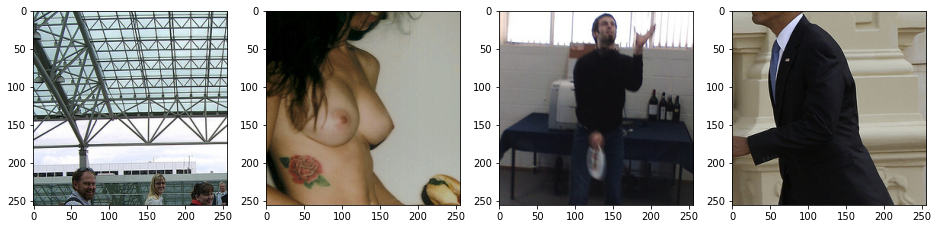

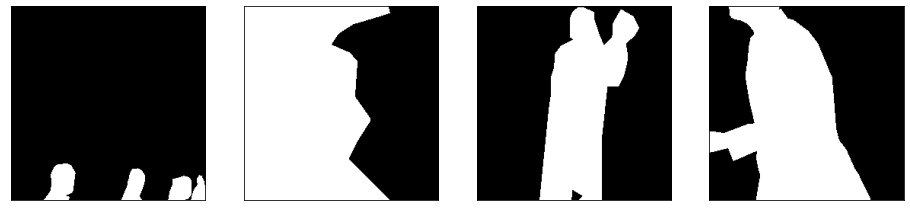

In [ ]:
samples = [x for x in iter(train_ds.take(4))]

fig = plt.figure(figsize=(16, 16))
for i in range(len(samples)):
    ax1 = fig.add_subplot(1, 4, i+1)
    ax1.imshow(samples[i][0][0])

fig = plt.figure(figsize=(16, 16))
for i in range(len(samples)):
    ax2 = fig.add_subplot(1, 4, i+1)
    ax2.imshow(samples[i][1][0].numpy().reshape(256, 256), cmap='gray')
    plt.xticks([]), plt.yticks([])
plt.show()

### Создание собственной модели

Построил неглубокую нейросеть, но с сохранением SOTA-принципов:

- Энкодер: 2 по (Conv2d + MaxPooling)
- Декодер: 2 по (UnPooling + Upscale)
- ASPP-сердцевина (1 шт)
- Skip Connection (1 шт)

In [ ]:
def build_model():
    x = tf.keras.layers.Input((256, 256, 3))
    
    # первый блок энкодера: Conv2D+MaxPool2D
    out = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    out1 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(out) # skip connection отсюда (здесь размер 256)
    out = tf.keras.layers.MaxPool2D((2, 2))(out1) # ----> 128

    # второй блок энкодера: Conv2D+MaxPool2D    
    out = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out) # ----> 64

    # ======================================
    # ASPP- дилатационная свертка: aspp1 для перемешивания, 2ой и 3ий как два варианта рецептивного поля

    aspp1 = tf.keras.layers.Conv2D(32, (1, 1), padding='same', activation='relu')(out)
    aspp2 = tf.keras.layers.Conv2D(16, (3, 3), dilation_rate=6, padding='same', activation='relu')(out)
    aspp3 = tf.keras.layers.Conv2D(16, (3, 3), dilation_rate=12, padding='same', activation='relu')(out)
    out = tf.concat([aspp1, aspp2, aspp3], axis=3) # соединить варианты
    out = tf.keras.layers.Conv2D(32, (1, 1), padding='same', activation='relu')(out) # снова перемешать и подать декодеру

    # ======================================

    # первый блок декодера: Conv2DTranspose+Conv2D
    out = tf.keras.layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='relu')(out) # ----> 128
    out = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(out) 

    # второй блок декодера: Conv2DTranspose+Conv2D
    out = tf.keras.layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='relu')(out) # ----> 256
    out = tf.concat([out1, out], axis=3)  # skip connection сюда (должен быть размер 256)

    # выход в один нейрон
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid')(out)

    return tf.keras.Model(inputs=x, outputs=out)

In [ ]:
model = build_model()

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

### Визуализация модели

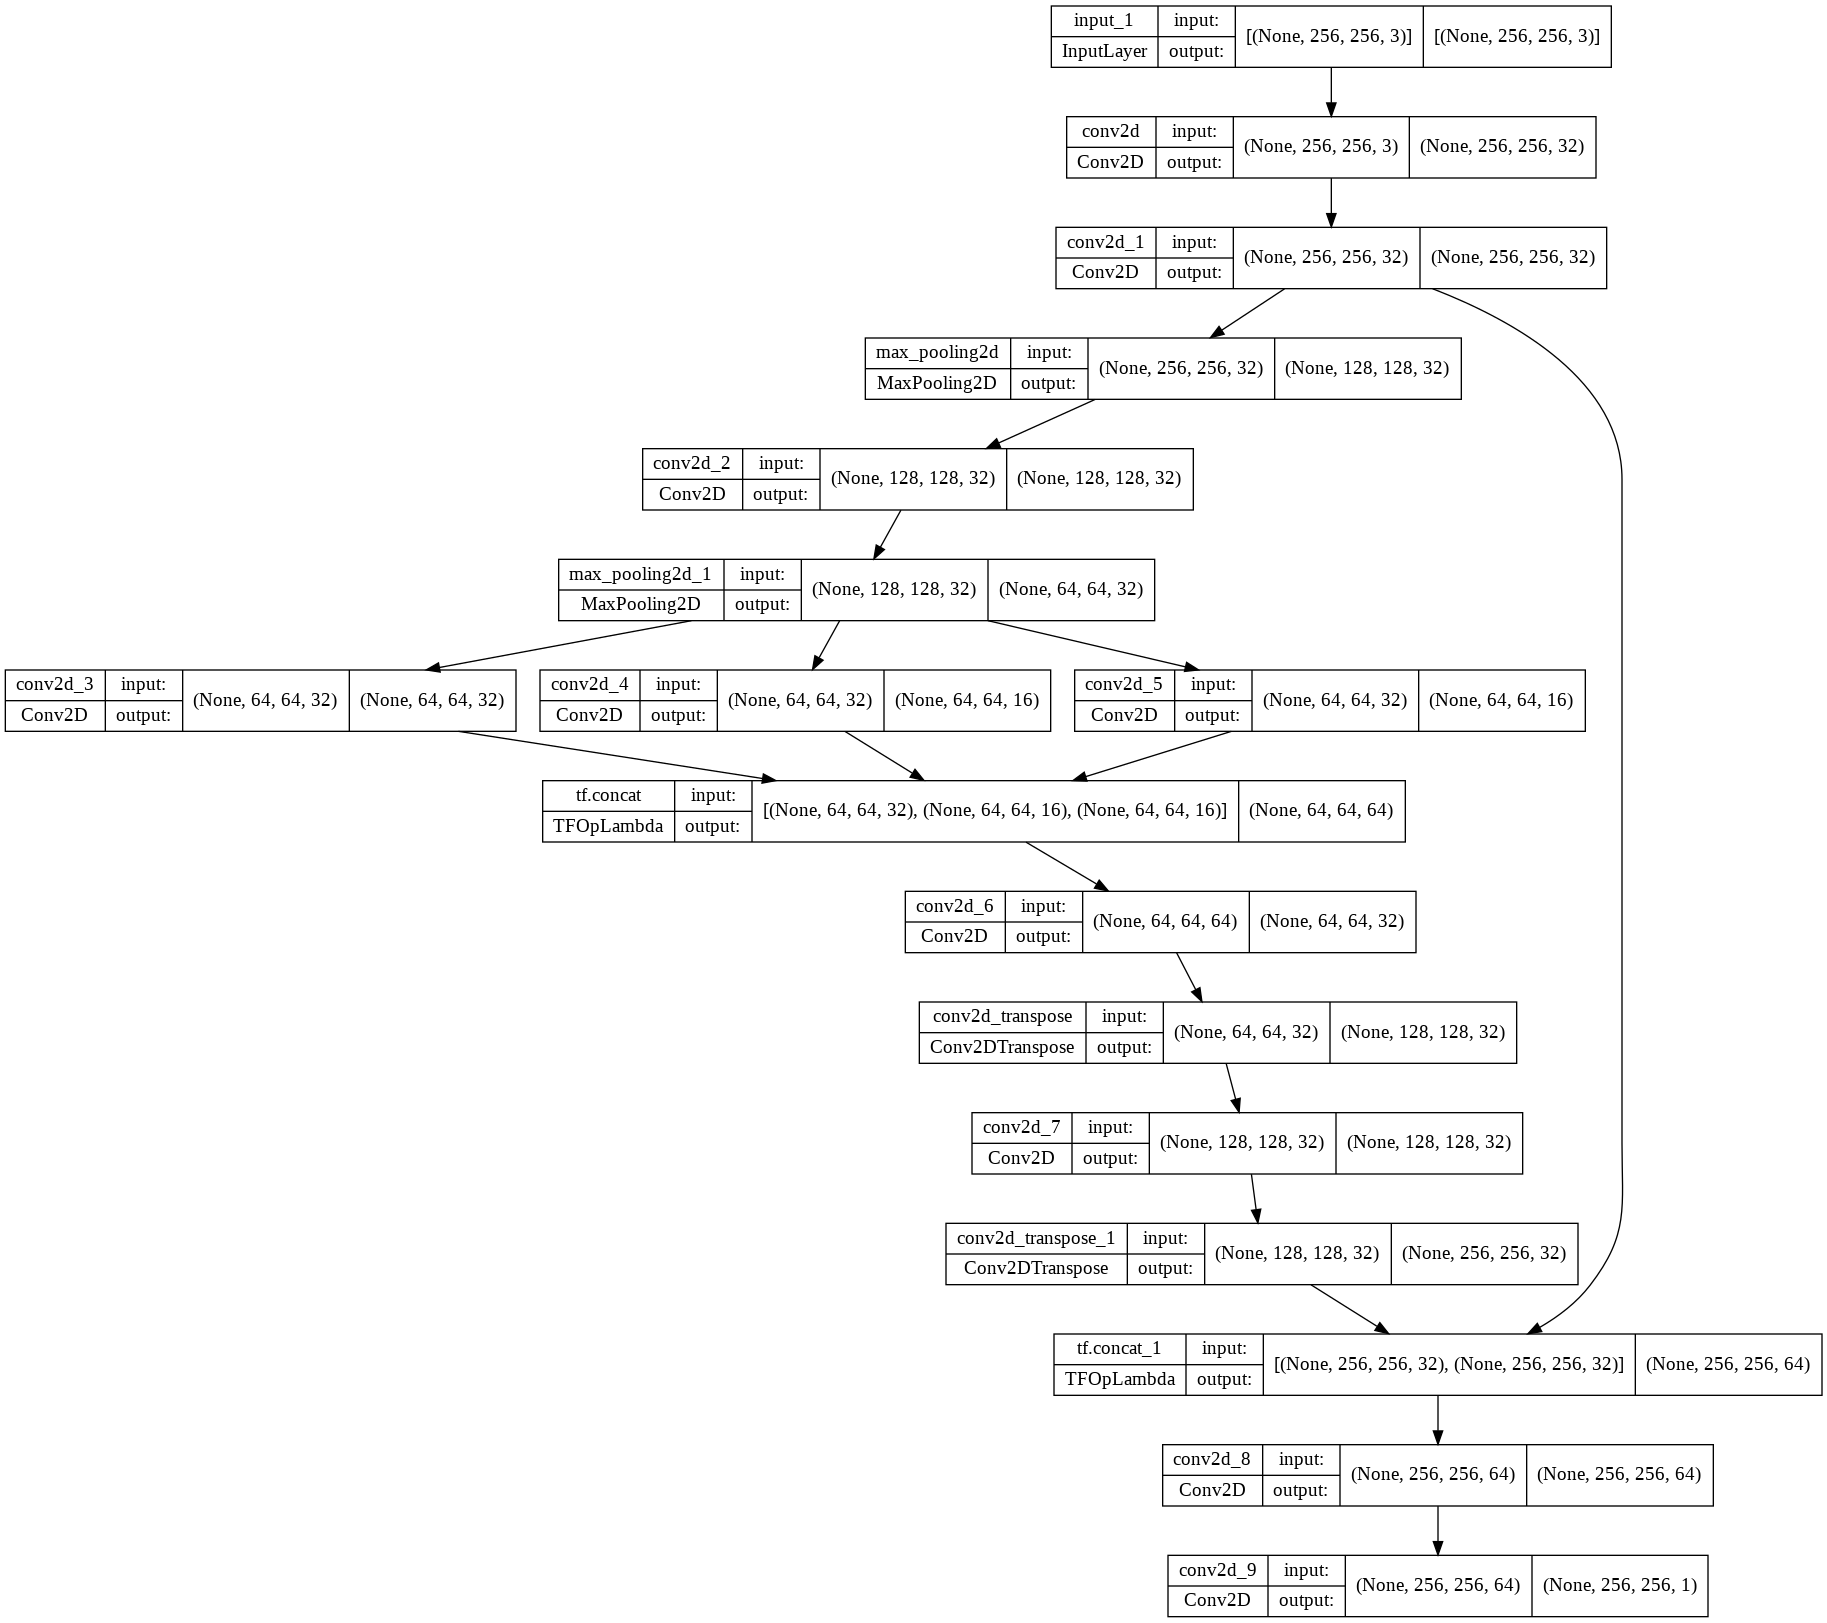

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

### Обучение нейросети

In [ ]:
LEARNING_RATE = 0.001

optimizer = tf.keras.optimizers.Nadam(LEARNING_RATE)
#optimizer = tf.keras.optimizers.RMSprop(LEARNING_RATE)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy'])

In [ ]:
%%time

hist = model.fit(
    train_ds,
    epochs=3
)

plt.plot(hist.history['loss'])

Здесь у меня **ResourceExhaustedError** (вывод скрыл, чтобы не занимал места).

Так как я все поставил на Colab, на работу с Jupyter времени до дедлайна не остается. 

Впрочем, метрика на тесте не ужасна. 

Главное, я самостоятельно кирпичик за кирпичиком построил простенькую архитектуру.

### Оценка на валидационном датасете

In [ ]:
model.evaluate(test_ds)

21/21 [==============================] - 54s 3s/step - loss: 0.6637 - accuracy: 0.7433


[0.6636860370635986, 0.7432599067687988]

In [ ]:
prediction = model.predict(test_ds)

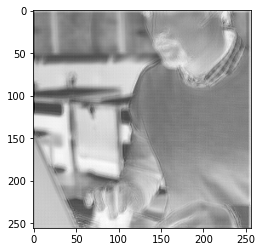

In [ ]:
plt.imshow(prediction[197].reshape(256, 256), cmap='gray')
plt.show()